# Here, we will try to add an extra layer in the network (fully connected layer, not convolutional layer)
## referring network from `notebook_02.ipynb`

In [11]:
# import required libraries
import numpy as np
import os, sys
import torch
# for plots
import matplotlib.pyplot as plt
# neural network modules
import torch.nn as nn
# PyTorch utilities
from torch.utils.data import DataLoader
# optimizers
import torch.optim as optim

# using functions written in 1st notebook instead of rewriting them again and again
# the functions are made into a module named `utilities` in the `src` directory 
import importlib
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
from src import utilities
from src.utilities import train_model, evaluate, plot_metrics, prediction_and_image, load_mnist_data, print_conclusion
importlib.reload(utilities)

<module 'src.utilities' from '/home/ravi/Desktop/deep-learning-projects/mnist-cnn/src/utilities.py'>

In [5]:
# set device to cuda(gpu)
if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [6]:
# load dataset
train_dataset, test_dataset = load_mnist_data()

### Build a deeper CNN
Adding a fully connected layer

In [7]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=24,kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=24,out_channels=48,kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.flatten = nn.Flatten()

        self.fc_linear_1 = nn.Linear(in_features=48*5*5, out_features=256)
        self.relu = nn.ReLU()

        self.fc_linear_2 = nn.Linear(in_features=256, out_features=10)
    
    def forward(self,X):
        X = self.conv1(X)
        X = self.relu(X)
        X = self.pool1(X)

        X = self.conv2(X)
        X = self.relu(X)
        X = self.pool2(X)

        X = self.flatten(X)
        X = self.fc_linear_1(X)
        X = self.relu(X)
        X = self.fc_linear_2(X)
        return X

The reason for adding one more fully connected (dense layer) is that it allows for our model to learn some additional feature. When the flattened inputs are directly converted to outputs (in all the previous cases), we are not allowing the model to learn the features extracted by our convolutional layers.

In [24]:
# instantiate the model and move to device
deeper_cnn_model_1 = CNN2().to(device)

# define batch size, dataloader, optimizer, and loss functions

# batch size
BATCHSIZE1 = 32
# dataloader
trainset_loader1 = DataLoader(train_dataset, BATCHSIZE1, shuffle=True)
testset_loader1 = DataLoader(test_dataset, BATCHSIZE1, shuffle=False)

# loss function (Cost Function)
loss_function = torch.nn.CrossEntropyLoss()
optimizer1 = optim.Adam(deeper_cnn_model_1.parameters())

EPOCHS = 20

# train the model
losses1, accuracies1 = train_model(deeper_cnn_model_1, trainset_loader1, loss_function, optimizer1, EPOCHS)

EPOCH: 1...
EPOCH: 2...
EPOCH: 3...
EPOCH: 4...
EPOCH: 5...
EPOCH: 6...
EPOCH: 7...
EPOCH: 8...
EPOCH: 9...
EPOCH: 10...
EPOCH: 11...
EPOCH: 12...
EPOCH: 13...
EPOCH: 14...
EPOCH: 15...
EPOCH: 16...
EPOCH: 17...
EPOCH: 18...
EPOCH: 19...
EPOCH: 20...


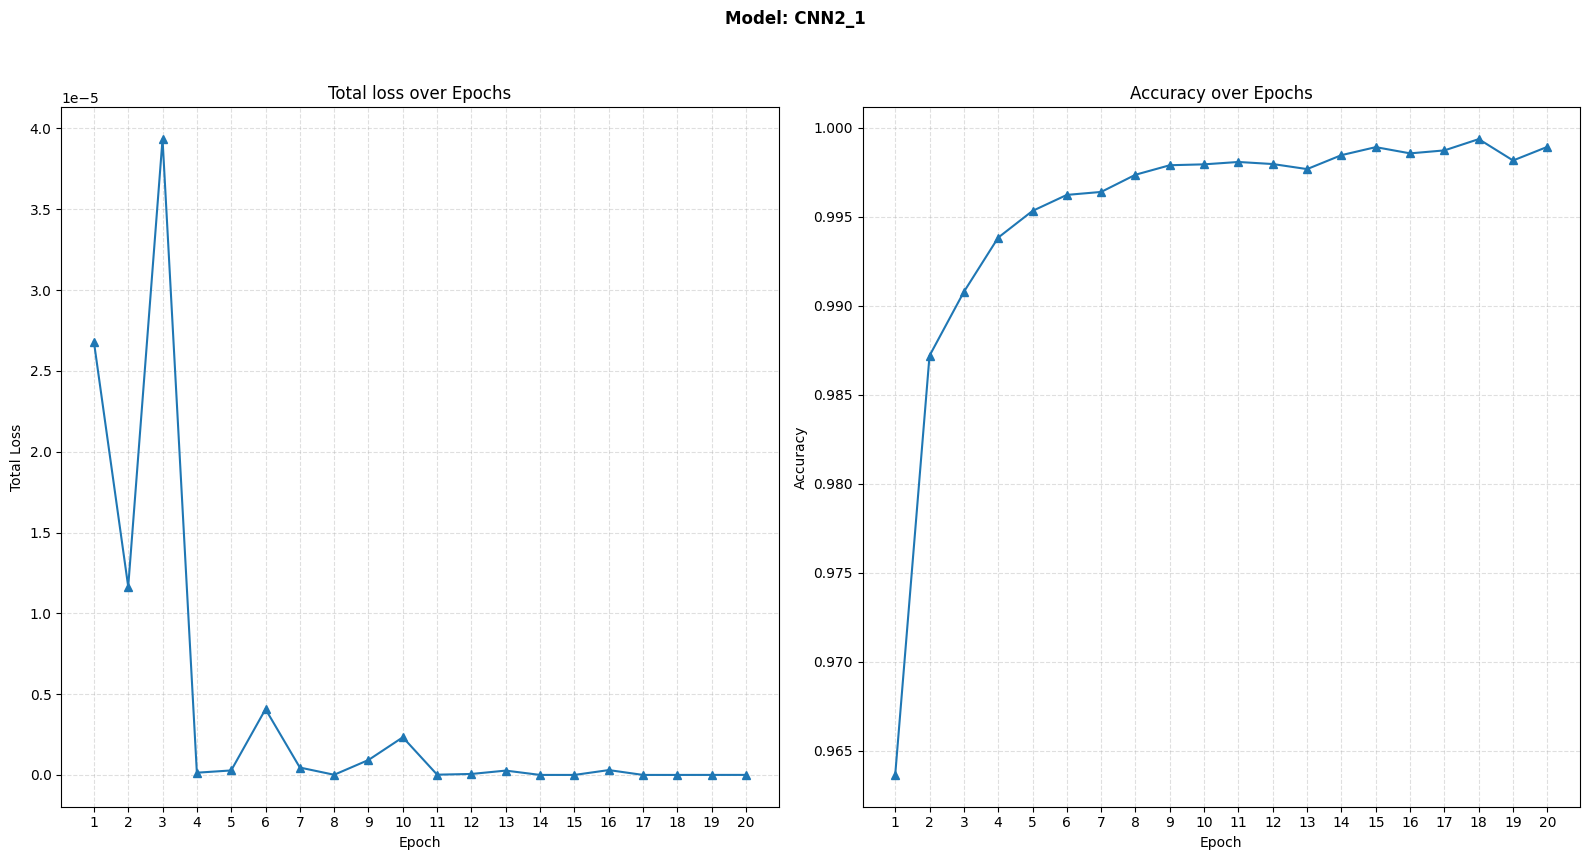

In [25]:
plot_metrics(losses1, accuracies1, "CNN2_1")

In [26]:
test_loss, test_accuracy = evaluate(deeper_cnn_model_1, testset_loader1, loss_function)
print_conclusion("CNN1", losses1, accuracies1, test_loss, test_accuracy)

Model: CNN1
Loss(Training): 0.000000
Accuracy(Training): 0.998917
Loss(Testing): 0.000006
Accuracy(Testing): 0.990900


In [28]:
# saving the model
from pathlib import Path

CHECKPOINT = Path("../checkpoints")
CHECKPOINT.mkdir(parents=True, exist_ok=True)

CHECKPOINT_NAME = "CNN2_2.pt"
CHECKPOINT_PATH = CHECKPOINT/CHECKPOINT_NAME

state = {
        'epochs' : EPOCHS,
        'model_state_dict': deeper_cnn_model_1.state_dict(),
        'optimizer_state_dict': deeper_cnn_model_1.state_dict(),
        'losses': losses1,
        'accuracies': accuracies1,
        'batch_size': BATCHSIZE1,
        'learning_rate': "default"
    }
torch.save(state, CHECKPOINT_PATH)
print(f"Model saved successfully to {CHECKPOINT_PATH}")

Model saved successfully to ../checkpoints/CNN2_2.pt


## Playing with the hyperparameters:

### 1. SETTING LR = 0.1
![alt text](../images-for-notebooks/lr_0.1.png)
We see that the model becomes unstable.(which is common for large learning rates)
___________________________________________________


### 2. BATCHSIZE = 512
![alt text](../images-for-notebooks/batchsize_512.png)
**Larger batchsize may help the model to converge faster.**<br>
Well, that's what has happened here. Accuracy reached above 98% in the first 2-3 epochs itself. This cuts down training time and computational resources.

Faster convergence can be evident from the fact that, for **BATCHSIZE=32**, it almost took 17 epochs to converge (plot shown below.)

![alt text](../training-plots/CNN2_1.png)

**Note:**

Careful observation of the above immediate 2 plots reveals that, for larger batches of data, the loss optimization is quite unstable. Whereas for the batchsize of 32, loss optimization is stable. This indicates the significance of smaller batchsizes.

**Tradeoff:**

Larger batchsize, unstable loss optimization, slight reduction in accuracy -- but, faster convergence

Smaller batchsize, stable loss optimization, imporved accuracy -- but, slower convergence.
___________________________________________________